# Разработка A/B-тестирования и анализ результатов

## Цель: ## 
проверить гипотезу об эффективности новой рекомендательной системы в развлекательном приложении с помощью А/В теста.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задачи
1. Рассчитать параметры теста.
2. Оценить корректность его проведения. 
3. Проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest
from math import ceil
from scipy.stats import ttest_ind

In [3]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

In [4]:
#Для каждого уникального пользователя рассчитаем количество уникальных сессий
sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique()

#Выведем данные пользователя с наибольшим кол-вом сессий
top_user = sessions_per_user.sort_values(ascending=False).head(1).index[0]
sessions_history[sessions_history['user_id']==top_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

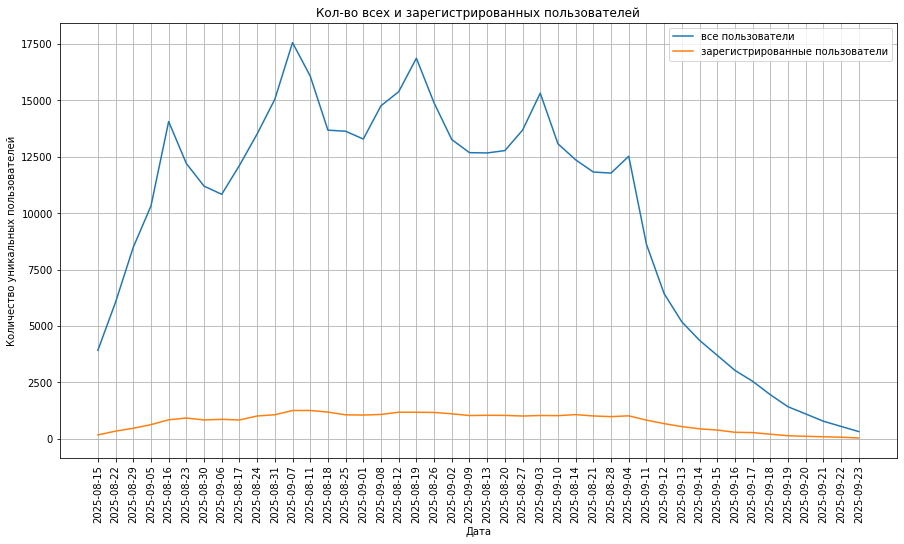

In [5]:
#Построим линейный график общего числа пользователей и общего числа зарегистрированных пользователей по дням
x = sessions_history['session_date'].unique()
y_a = sessions_history.groupby('session_date')['user_id'].nunique()
y_b = sessions_history[sessions_history['registration_flag']==1].groupby('session_date')['user_id'].nunique()

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='все пользователи')
plt.plot(x, y_b,label ='зарегистрированные пользователи')

plt.xlabel("Дата")
plt.ylabel("Количество уникальных пользователей")
plt.legend()
plt.title('Кол-во всех и зарегистрированных пользователей')
plt.xticks(rotation=90)
plt.grid()
plt.show()

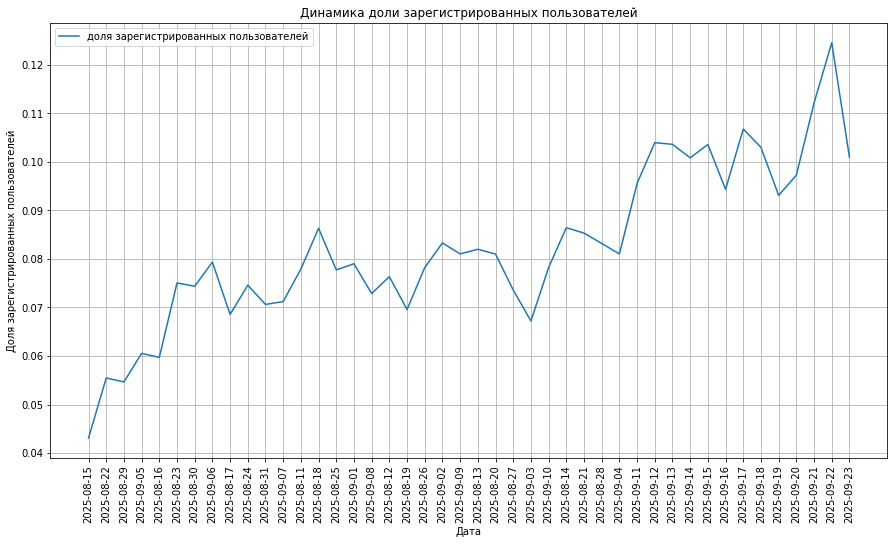

In [6]:
#Построим линейный график доли зарегистрированных пользователей от всех пользователей по дням
y = y_b/y_a
plt.figure(figsize=(15, 8))
plt.plot(x, y, label ='доля зарегистрированных пользователей')

plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных пользователей")
plt.legend()
plt.title('Динамика доли зарегистрированных пользователей')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### 1.4. Анализ числа просмотренных страниц

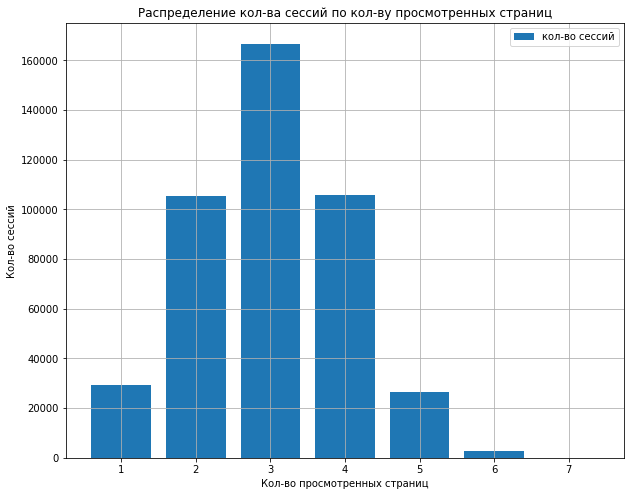

In [7]:
#Найдем количество сессий для каждого значения количества просмотренных страниц
sessions_per_page_counter = sessions_history.groupby('page_counter')['session_id'].nunique()

#Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(sessions_per_page_counter.index, sessions_per_page_counter.values, label ='кол-во сессий')

plt.xlabel("Кол-во просмотренных страниц")
plt.ylabel("Кол-во сессий")
plt.legend()
plt.title('Распределение кол-ва сессий по кол-ву просмотренных страниц')
plt.grid()
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

In [8]:
#Создадим новый столбец-индентификатор успешной сессии
sessions_history['good_sessions'] = 0
def good_session(row):
    if row['page_counter'] >= 4:
        return 1
    else:
        return 0

sessions_history['good_sessions'] = sessions_history.apply(good_session, axis=1)

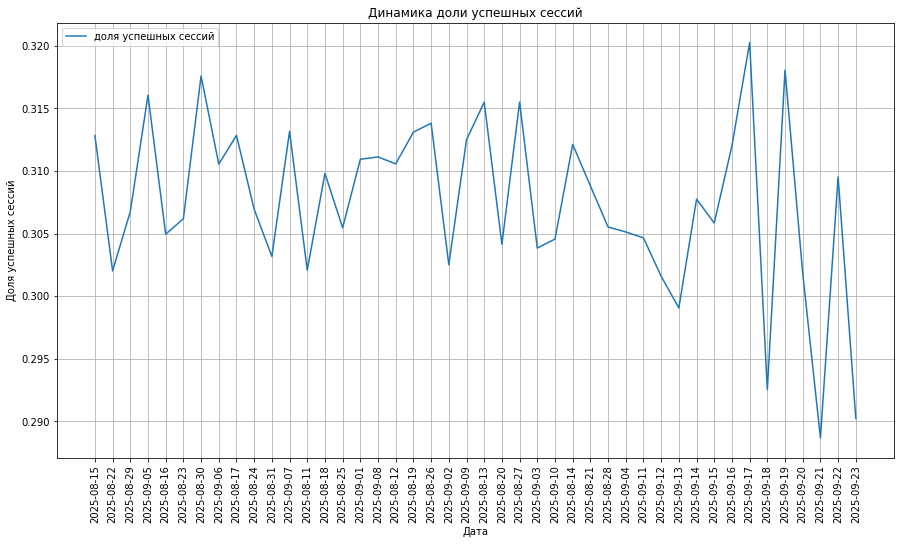

In [9]:
#Построим график со средним значением доли успешных сессий от всех сессий по дням
good_sessions_share = sessions_history.groupby('session_date')['good_sessions'].mean()
plt.figure(figsize=(15, 8))
plt.plot(x, good_sessions_share, label ='доля успешных сессий')

plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий")
plt.legend()
plt.title('Динамика доли успешных сессий')
plt.xticks(rotation=90)
plt.grid()
plt.show()

### 2. Подготовка к тесту

#### 2.1 Формулировка нулевой и альтернативной гипотез

Нулевая гипотеза:
 - Доля успешных сессий до внедрения новой рекомендательной системы и после не отличается. 

Альтернативная гипотеза:
- Доля успешных сессий после внедрения новой рекомендательной системы увеличилось. 

#### 2.2. Расчёт размера выборки

In [10]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

In [11]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907.363636363636 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста по данным за 1 день

#### 3.1. Проверка распределения пользователей

In [13]:
#Рассчитаем кол-во уникальных пользователей в каждой группе
sessions_test_part.groupby(['session_date','test_group'])['user_id'].nunique()

session_date  test_group
2025-10-14    A             1477
              B             1466
Name: user_id, dtype: int64

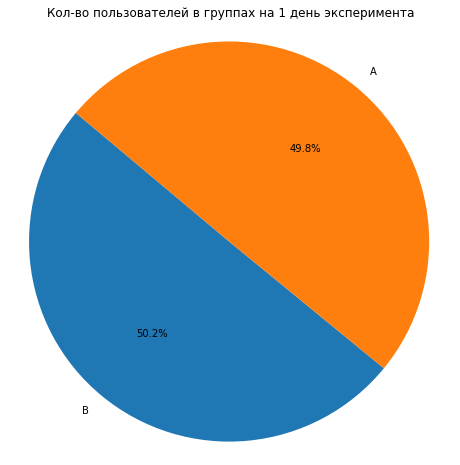

'Кол-во пользователей в группах А и В отличается на 0.7447528774542993%'

In [14]:
#Построим круговую диаграмму
group_a = sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()
group_b = sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique()

labels = sessions_test_part['test_group'].unique()
sizes = [group_a,group_b]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title("Кол-во пользователей в группах на 1 день эксперимента")

plt.show()

p = 100 * abs((group_a-group_b))/group_a
display(f'Кол-во пользователей в группах А и В отличается на {p}%')

#### 3.2. Проверка пересечений пользователей

In [15]:
#Проверим, что пользователи в группах не пересекаются
a = sessions_test_part[sessions_test_part['test_group']=='A']['user_id']
b = sessions_test_part[sessions_test_part['test_group']=='B']['user_id']

intersection = list(set(a) & set(b))
print(intersection) 

[]


#### 3.3. Равномерность разделения пользователей по устройствам

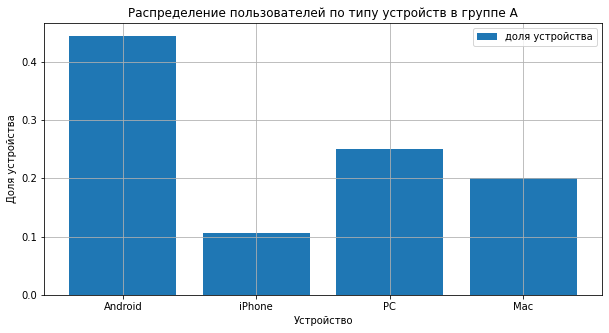

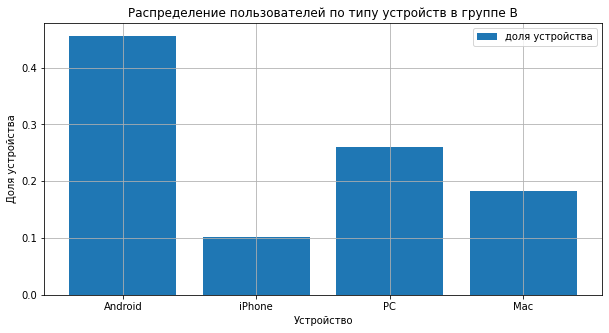

In [25]:
#Выведем распределение пользователей по типу устройств
device_share_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('device')['user_id'].nunique()/sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()
device_share_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('device')['user_id'].nunique()/sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique()

plt.figure(figsize=(10, 5))
plt.bar(sessions_test_part['device'].unique(),device_share_a, label ='доля устройства')

plt.xlabel("Устройство")
plt.ylabel("Доля устройства")
plt.legend()
plt.title('Распределение пользователей по типу устройств в группе A')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(sessions_test_part['device'].unique(),device_share_b, label ='доля устройства')

plt.xlabel("Устройство")
plt.ylabel("Доля устройства")
plt.legend()
plt.title('Распределение пользователей по типу устройств в группе B')
plt.grid()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам

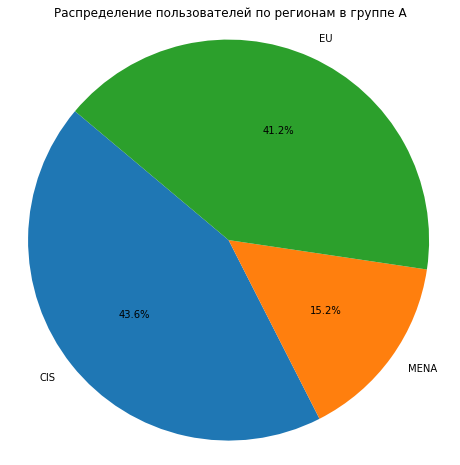

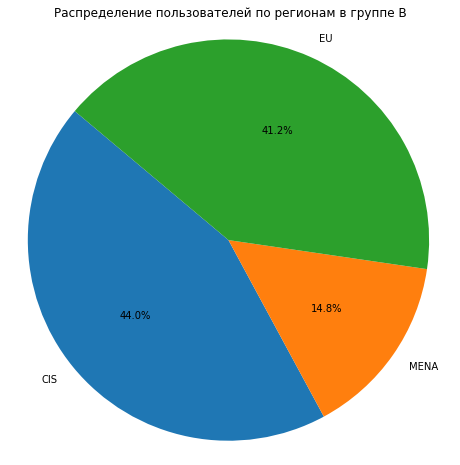

In [17]:
#Выведем распределение пользователей по типу регионам
region_share_a = sessions_test_part[sessions_test_part['test_group']=='A'].groupby('region')['user_id'].nunique()/sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()
region_share_b = sessions_test_part[sessions_test_part['test_group']=='B'].groupby('region')['user_id'].nunique()/sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique()

labels_a = sessions_test_part['region'].unique()
sizes_a = list(region_share_a)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes_a, labels=labels_a, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Равномерное отображение оси
plt.title("Распределение пользователей по регионам в группе А")

plt.show()

labels_b = sessions_test_part['region'].unique()
sizes_b = list(region_share_b)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes_b, labels=labels_b, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Равномерное отображение оси
plt.title("Распределение пользователей по регионам в группе В")

plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведенного анализа А/В теста было выявлено, что:
- различие в кол-ве пользователей в группах А и В составляет менее 1%, что говорит о равном распределении пользователей между группами
- выборки являются независимыми, так как нет пользователей, уоторые присутствуют в обеих группах одновременно
- распределение пользователей обеих групп по устройствам и регионам сохраняется равномерным

Следовательно, А/В тест проходит корректно.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики


In [19]:
#Создадим столбец с кол-вом успешных сессий
sessions_test['good_sessions'] = 0
sessions_test['good_sessions'] = sessions_test.apply(good_session, axis=1)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_sessions
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

In [20]:
#Применим тест Уэлча для проверки равенства кол-ва уникальных сессий в двух выборках
metric_a = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].nunique()
metric_b = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].nunique()

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    alternative='two-sided' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки (metric_a) меньше второй выборки
) ## применяем t-тест Уэлча
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: кол-во уникальных сессий для каждого дня в двух выборках не различается')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: кол-во уникальных сессий для каждого дня в двух выборках различается')

p-value теста Уэлча = 0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: кол-во уникальных сессий для каждого дня в двух выборках не различается


#### 4.3. Сравнение доли успешных сессий

In [21]:
good_sessions_share_a = sessions_test[sessions_test['test_group']=='A']['good_sessions'].mean()
good_sessions_share_b = sessions_test[sessions_test['test_group']=='B']['good_sessions'].mean()
good_sessions_share_a,good_sessions_share_b
p2 = 100 * abs((good_sessions_share_a-good_sessions_share_b))/good_sessions_share_a
p2
display(f'Доля успешных сессий в группе А составила {good_sessions_share_a}, а в группе В - {good_sessions_share_b} . Разница в показателе составляет {p2}%')

'Доля успешных сессий в группе А составила 0.3077233557344958, а в группе В - 0.31828992745867524 . Разница в показателе составляет 3.433789319942396%'

#### 4.4. Насколько статистически значимо изменение ключевой метрики

In [22]:
#Применим Z-тест пропорций для проверки нулевой и альтернативной гипотез
n_a = sessions_test[sessions_test['test_group']=='A'].shape[0]
n_b = sessions_test[sessions_test['test_group']=='B'].shape[0]

m_a = sessions_test[sessions_test['test_group']=='A']['good_sessions'].sum() 
m_b = sessions_test[sessions_test['test_group']=='B']['good_sessions'].sum() 

p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10): 
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05 


stat_ztest, p_value_ztest = proportions_ztest( 
	[m_a, m_b],
	[n_a, n_b],
	alternative="smaller"
)

print(f'pvalue={p_value_ztest}') 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')


Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

А/В тест проводился с целью проверить эффективность новой рекомендательной системы. Основная гипотеза заключалась в том, что после внедрения новой системы доля успешных сессий увеличится.
Эксперимент проводился в период с 2025-10-14 по 2025-11-02 и задействовал 30579 пользователей.

Заданные параметры эксперимента:
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Минимальный детектируемый эффект — 3%.

Внедрение нового алгоритма увеличило ключевую метрику с 30,77% до 31,82%, то есть примерно на 1,1%.
Как показал z-тест пропорций, это изменение является статистически значимым: pvalue=0.0001574739988036123 меньше уровня значимости, равного 0.05.

Следовательно, нововведение стоит внедрить в приложение.
